## Imports and dependencies

In a first time, we load all the external Python librairies needed for the rest of the file


In [1]:
import datetime

import keras
import keras.layers
import numpy as np
import pandas as pd
from keras import metrics
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

class MyTQDMNotebookCallback(TQDMNotebookCallback):
    def tqdm(self, desc, total, leave, initial=0):
        """
        Extension point. Override to provide custom options to tqdm initializer.
        :param desc: Description string
        :param total: Total number of updates
        :param leave: Leave progress bar when done
        :param initial: Initial counter state
        :return: new progress bar
        """
        return tqdm(desc=desc, total=total, leave=leave, file=self.output_file, initial=initial, ncols='100%')

Using TensorFlow backend.


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

As usual, we change our working directory to go to the root of the project. The working diretory should be 
something like 'xxx\Roll Wear Project'

In [3]:
from src.notebooks.utils_notebooks import move_current_path_up
move_current_path_up(n_times=2)

Working directory = P:\My Documents\Projets Programmation\Roll Wear Project


# DATA

## Loading data

We load the previously preprocessed data.

Those data are the inputs, which are the strips of all the campaigns and the outputs, which are wears at the centre for all the campaigns.

In [4]:
input_df = pd.read_hdf('Data/notebooks_data/wear_center_preprocessed.h5', key='inputs')
output_df = pd.read_hdf('Data/notebooks_data/wear_center_preprocessed.h5', key='outputs')


## Splitting data

Then, we split the data into train/dev/test sets. To do that, we first need to identify the remaining campaigns, and 
then we will split those campaigns id, which will be used after to select the corresponding data.

In [5]:
campaigns_list = np.intersect1d(output_df.index, input_df.index.get_level_values('id_campaign').unique())

camp_train, _camp_devtest = train_test_split(campaigns_list, test_size=0.33)
camp_dev, camp_test = train_test_split(_camp_devtest, test_size=0.33)

print('Number of train campaigns: %d \nNumber of dev   campaigns: %d \nNumber of test  campaigns: %d' % (camp_train.size, camp_dev.size, camp_test.size))


Number of train campaigns: 217 
Number of dev   campaigns: 72 
Number of test  campaigns: 36


## Normalizing data

Before training our model, we will need to *normalize/standardize* our data. This operation has to be done, like the 
training, on the train set and applied on all sets, to be comparable with real-life situation, where only the training 
set would first be available.

In [6]:
from sklearn.preprocessing import MinMaxScaler

class MyScaler:
    def __init__(self):
        self.min = 0.0
        self.max = 1.0
    
    def fit(self, var):
        self.min = np.min(var, axis=0)
        self.max = np.max(var, axis=0)
        return self
        
    def transform(self, var):
        return (var - self.min) / (self.max - self.min) 
    
    def fit_transform(self, var):
        self.fit(var)
        return self.transform(var)

    def inverse_transform(self, var):
        try:
            return var * (self.max - self.min) + self.min
        except ValueError:
            return var * np.transpose((self.max - self.min)) + np.transpose(self.min)

input_scaler = MinMaxScaler().fit(input_df.loc[camp_train])
output_scaler = MyScaler().fit(output_df.loc[camp_train])

input_norm = pd.DataFrame(data=input_scaler.transform(input_df), index=input_df.index, columns=input_df.columns)
output_norm = pd.DataFrame(data=output_scaler.transform(output_df), index=output_df.index, columns=output_df.columns)


# NEURAL NETWORK

## Functions creating the Models

The following functions create the full model of the Roll Wear prediction, and the Neural Net used in it. 
This part may be the trickiest one of those files, as the structure of the neural network here is quite complicated.

### Common Neural Network

Ths following functions create the Neural Network. This one is the same for all the models, the differences between 
further models being its integration (Recurrent Inputs, etc.).

In [7]:
from src.roll_wear_lib_functional.models import irsid_recurrent_nn

### Function to format data for the NN

The Neural Network, because of its particular shape, needs the data to be formateed in an 'un-natural' way. 
The following function is used for that: given a list of campaigns (like the train campaigns for instance), 
it would return the formated inputs and outputs for the Neural Net.

In [9]:
# First, we create a DataFrame storing the values of F/w * L needed by the IRSID model. 
# Those values can also be normalized if necessary... This can be tested 
fwl_df: pd.DataFrame = pd.read_hdf('Data/notebooks_data/wear_center.h5', key='inputs')
fwl_df = fwl_df[['STRIP LENGTH F6 EXIT*', 'STRIP LENGTH F7 EXIT', 'STAND FORCE / WIDTH F6*', 'STAND FORCE / WIDTH F7*']]
fwl_df['FwL F6'] = fwl_df['STRIP LENGTH F6 EXIT*'] * fwl_df['STAND FORCE / WIDTH F6*'] 
fwl_df['FwL F7'] = fwl_df['STRIP LENGTH F7 EXIT'] * fwl_df['STAND FORCE / WIDTH F7*'] 

fwl_scaler = MinMaxScaler().fit(fwl_df.loc[camp_train])
fwl_norm = pd.DataFrame(data=fwl_scaler.transform(fwl_df), index=fwl_df.index, columns=fwl_df.columns)


In [10]:
from src.roll_wear_lib_functional.models import irsid_data_formating

try:
    data_format = lambda campaign_ids: irsid_data_formating(campaign_ids, input_norm, output_norm, fwl_norm)
except NameError:
    data_format = lambda campaign_ids: irsid_data_formating(campaign_ids, input_norm, output_norm, fwl_df)    

# TRAINING

## Defining training parameters

In the following cells are defined the main parameters of the model, neural net and training, to tune them.

In [19]:
loss = 'mse'    # 'mse' or 'mae'
epochs = 500


In [20]:
seq_length = input_df.index.get_level_values('id_strip').max()  # Max id of a strip in a campaign
input_length, output_length = len(input_df.columns), len(output_df.columns)

# model = irsid_nn((20, 8), ('selu', 'softsign', 'sigmoid'), seq_length, input_length, output_length)
model = irsid_recurrent_nn((20, 8), ('selu', 'softsign', 'sigmoid'), seq_length, input_length, output_length)


## Formating data and compiling the model

Formating data for the neural network

In [21]:
def mae_rw(y_true, y_pred):
    """ Returns the Mean Absolute Error of the given input, after denormalizing them.
     The values are given in µm (for Roll Wears) """
    y_true_unscale = 1000 * output_scaler.inverse_transform(y_true)
    y_pred_unscale = 1000 * output_scaler.inverse_transform(y_pred)
    return metrics.mae(y_true_unscale, y_pred_unscale)

log_dir="Data\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch=0)
tqdm_callback = MyTQDMNotebookCallback(
    leave_inner=False, metric_format="{name}: {value:.2e}", 
    inner_description_initial="Epoch: {epoch}",inner_description_update="Epoch: {epoch} - {metrics}")
early_stop_callback = EarlyStopping('val_mae_rw', min_delta=0.1, patience=15, mode='min', restore_best_weights=True)

# Compiling model
model.compile('adam', loss=loss, metrics=[mae_rw])

# Getting formated data
x_train, y_train = data_format(camp_train)
x_test, y_test = data_format(camp_test)
x_dev, y_dev = data_format(camp_dev)


## Training visualization

The following cells will show the *Tensorboard* web page to follow the evolution of the training in live.

To get a better view, you can open http://localhost:6006/#scalars in a new window of your web browser

In [1]:
# %tensorboard --logdir Data/logs/fit --reload_interval 1.0 --host localhost


## Training

In [23]:
# Training model
model.fit(x=x_train, y=y_train, epochs=epochs, validation_data=(x_dev, y_dev), batch_size=16, verbose=0, 
          callbacks=[early_stop_callback, tensorboard_callback, tqdm_callback])


## RESULTS

## Plotting training history

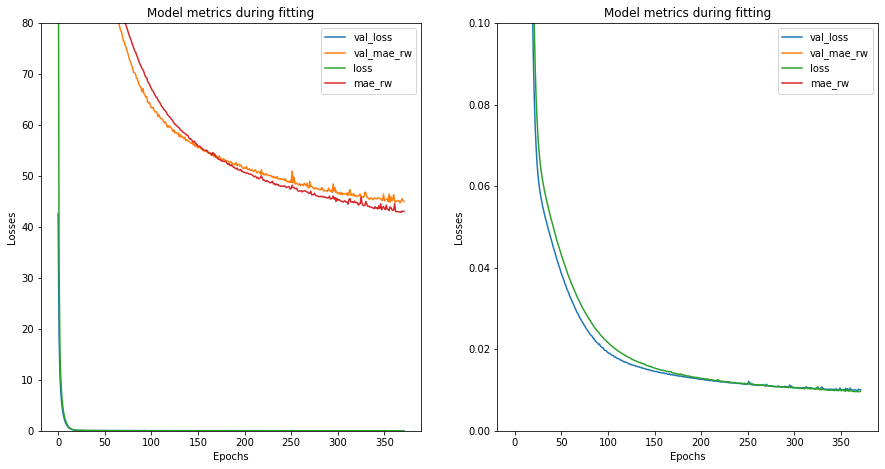

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7.5]

def plot_history(_model: keras.Model):
    """ Plot the evolution of the accuracy and loss of the model fit """
    history = _model.history
    plt.figure()
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        for key in history.history.keys():
            plt.plot(history.history[key], label=key)

        plt.title('Model metrics during fitting')
        plt.ylabel('Losses')
        plt.xlabel('Epochs')
        plt.legend()
        
        plt.ylim([0, 80])

    # On the second graph, we apply a zoom on the last details of convergence
    plt.ylim([0, 0.10])

plot_history(model)


### Plotting results

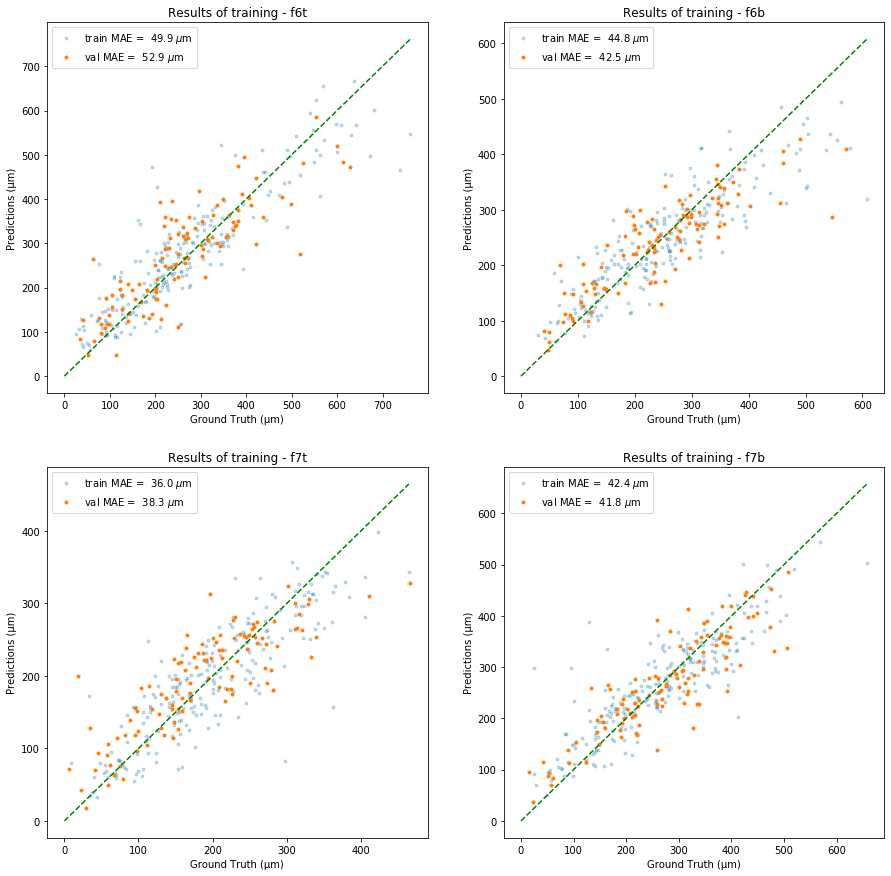

In [25]:
import os

def plot_results(_model: keras.Model, savefolder_name: str = None):
    """ Plots the results of the model, for each roll
    
    :param _model: Previoulsy trained model
    :param savefolder_name: Name of the folder in which results will be saved as csv. If None, nothing is saved
    """
    camp_val = _camp_devtest
    plt.rcParams['figure.figsize'] = [15, 15]

    def plot_one_roll(y_tr, y_va, pred_tr, pred_va, name: str):
        mae_train, mae_val = keras.metrics.mae(y_tr, pred_tr), keras.metrics.mae(y_va, pred_va)

        plt.plot(y_tr, pred_tr, '.', alpha=0.25, label='train' + r' MAE =  %.1f $\mu$m' % mae_train)
        plt.plot(y_va, pred_va, '.', label='val' + r' MAE =  %.1f $\mu$m' % mae_val)
        plt.plot([0, y_tr.max()], [0, y_tr.max()], '--g')

        plt.title('Results of training - ' + name)
        plt.xlabel('Ground Truth (µm)')
        plt.ylabel('Predictions (µm)')
        plt.legend()

        if savefolder_name is not None:
            df_tr = pd.DataFrame(index=camp_train)
            df_tr['Prediction (µm)'] = pred_tr
            df_tr['Ground Truth (µm)'] = y_tr

            df_va = pd.DataFrame(index=camp_val)
            df_va['Prediction (µm)'] = pred_va
            df_va['Ground Truth (µm)'] = y_va

            path = 'Data/notebooks_data/' + savefolder_name + '/'
            try:
                os.mkdir(path)
            except FileExistsError:
                pass
        
            df_tr.to_csv(path + 'results_train_' + name + '.csv', index=True,
                         float_format='%.2f')
            df_va.to_csv(path + 'results_val_' + name + '.csv', index=True,
                         float_format='%.2f')

    # Getting data
    x_trn, y_trn = data_format(camp_train)
    x_val, y_val = data_format(camp_val)
    pred_train, pred_val = _model.predict(x_trn), _model.predict(x_val)
    pred_train = pd.DataFrame(data=pred_train, index=y_trn.index, columns=y_trn.columns)
    pred_val = pd.DataFrame(data=pred_val, index=y_val.index, columns=y_val.columns)

    # De-normalisation and setting to µm
    y_trn, y_val, pred_train, pred_val = \
        output_scaler.inverse_transform(y_trn), output_scaler.inverse_transform(y_val), \
        output_scaler.inverse_transform(pred_train), output_scaler.inverse_transform(pred_val)
    y_trn, y_val, pred_train, pred_val = 1000 * y_trn, 1000 * y_val, 1000 * pred_train, 1000 * pred_val

    # Plotting results, roll by roll
    names = output_df.keys()
    plt.figure()
    for i in range(y_trn.shape[-1]):
        plt.subplot(2, np.ceil(y_trn.shape[-1] / 2), i + 1)
        key = names[i]
        plot_one_roll(y_trn[key], y_val[key], pred_train[key], pred_val[key], names[i])

plot_results(model, 'demo')
